In [1]:
from fifipy.fit import fitAllSlopes
from fifipy.io import readData

In [2]:
rootdir = '/Users/dfadda/sofia/FIFI-LS/SpectralFlats/'
caldir = 'calsource_flat_02_2018/'

In [3]:
from glob import glob as gb
directory = rootdir+caldir+'D105M1_1/'
files = gb(directory+'*.fits')

In [4]:
aor, hk, gratpos, flux = readData(files[0])

In [5]:
spectra = fitAllSlopes(flux)

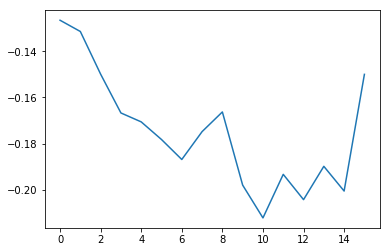

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(spectra[0,:,3])

In [7]:
from fifipy.calib import waveCal
obsdate,pos,xy,an,za,alti,wv = hk
detchan, order, dichroic, ncycles, nodbeam, filegpid, filenum = aor
w, dw = waveCal(gratpos, dichroic, obsdate, detchan, order)

In [9]:
import numpy as np
print(np.shape(w))

(25, 16)


In [27]:
gpos = [gratpos, gratpos+100, gratpos+300]
from fifipy.calib import computeAllWaves

w,dw = computeAllWaves(gpos, dichroic, obsdate, detchan, order)

print(np.shape(w))

(3, 25, 16)


In [23]:
from dask import delayed, compute
wavegpos = [delayed(waveCal)(g, dichroic, obsdate, detchan, order) for g in gpos]
waves = compute(* wavegpos, scheduler='processes')
print(np.shape(waves))

(3, 2, 25, 16)


In [25]:
nw = len(gpos)
wave = []
dwave = []
for w in waves:
    wave.append(w[0])
    dwave.append(w[1])


(3, 25, 16) <class 'list'>


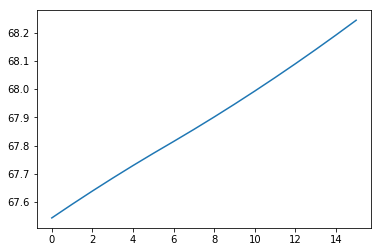

In [20]:
plt.plot(wave[1,12,:])

In [1]:
from glob import glob as gb
from fifipy.io import readData, saveSlopeFits
from fifipy.calib import computeAllWaves
from fifipy.fit import fitAllSlopes

# Calibration data directory
rootdir = '/Users/dfadda/sofia/FIFI-LS/SpectralFlats/'
caldir = 'calsource_flat_02_2018/'
for k in range(1,4):
    kstr = str(k)
    directory = rootdir + caldir+'D105M1_'+kstr+'/'
    files = gb(directory+'*.fits')
    gpos = []
    specs = []
    for i, f in enumerate(files):
        if i%10 == 0:
            print (i//10, end='', flush=True)
        else:
            print ('.',end='', flush=True)
        aor, hk, gratpos, flux = readData(f)
        spectra = fitAllSlopes(flux)
        specs.append(spectra[0,:,:])
        gpos.append(gratpos[0])
        
    print('Compute wavelengths ')
    obsdate,pos,xy,an,za,alti,wv = hk
    detchan, order, dichroic, ncycles, nodbeam, filegpid, filenum = aor
    wave, dwave = computeAllWaves(gpos, dichroic, obsdate, detchan, order)
    outname = rootdir + caldir + 'D105M1_'+kstr+'.fits'
    saveSlopeFits(gpos, dichroic, obsdate, detchan, order, specs, wave, dwave, outname)

0.........1.........2.........3.........4.........5.........6.........7.........8.........9.........10.........11.........12.........13.........14.........15.........16.........17.........18.........19.........20.........21.........22.........23.........24.........25.........26.........27.........28.........29.........30.........31.........32.........33.........34.........35.........36.........37.........38.........39.........40.........41.........42.........43.........44.........45.........46.........47..Compute wavelengths 
0.........1.........2.........3.........4.........5.........6.........7.........8.........9.........10.........11.........12.........13.........14.........15.........16.........17.........18.........19.........20.........21.........22.........23.........24.........25.........26.........27.........28.........29.........30.........31.........32.........33.........34.........35.........36.........37.........38.........39.........40.........41.........42.........43...

In [4]:
from astropy.io import fits
filename = 'D105M1_1.fits'
hdl = fits.open(rootdir+caldir+filename)
hdl.info()
g1 = hdl['Grating Position'].data
w1 = hdl['WAVE'].data
dw1 = hdl['DWAVE'].data
s1 = hdl['SPECS'].data
hdl.close()
filename = 'D105M1_2.fits'
hdl = fits.open(rootdir+caldir+filename)
g2 = hdl['Grating Position'].data
w2 = hdl['WAVE'].data
dw2 = hdl['DWAVE'].data
s2 = hdl['SPECS'].data
hdl.close()
filename = 'D105M1_3.fits'
hdl = fits.open(rootdir+caldir+filename)
g3 = hdl['Grating Position'].data
w3 = hdl['WAVE'].data
dw3 = hdl['DWAVE'].data
s3 = hdl['SPECS'].data
hdl.close()

Filename: /Users/dfadda/sofia/FIFI-LS/SpectralFlats/calsource_flat_02_2018/D105M1_1.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       8   ()      
  1  Grating Position    1 ImageHDU         7   (473,)   int64   
  2  SPECS         1 ImageHDU         9   (25, 16, 473)   float64   
  3  WAVE          1 ImageHDU         9   (16, 25, 473)   float64   
  4  DWAVE         1 ImageHDU         9   (16, 25, 473)   float64   


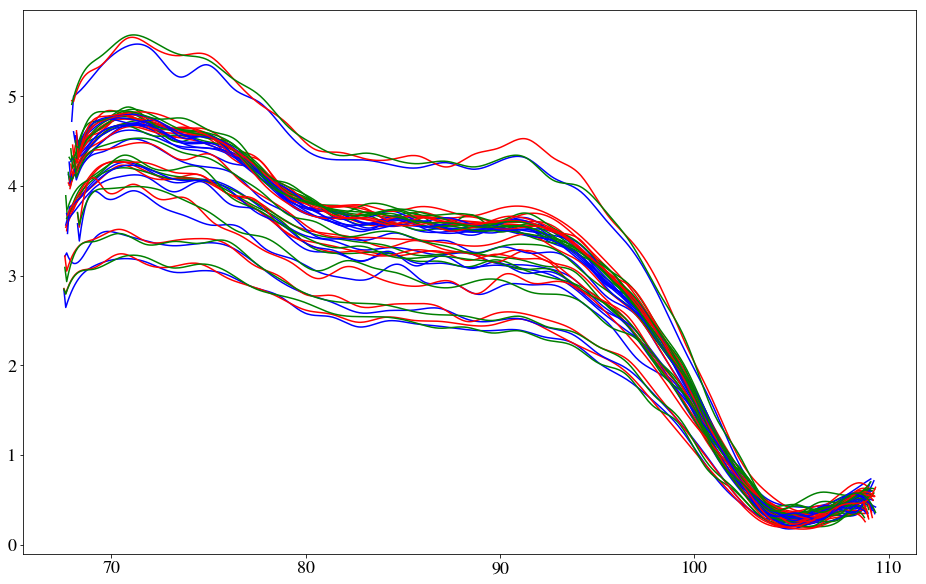

In [7]:
%matplotlib inline
from matplotlib import rcParams
rcParams['font.family']='STIXGeneral'
rcParams['font.size']=18
rcParams['mathtext.fontset']='stix'
rcParams['legend.numpoints']=1
import matplotlib.pyplot as plt
from scipy.interpolate import LSQUnivariateSpline
from scipy.interpolate import interp1d
from astropy.stats.biweight import biweight_location, biweight_scale
import numpy as np

ispex = 14
ispax = 2
fig, ax = plt.subplots(figsize=(16, 10))
for ispex in range(16):
    x1 = w1[:,ispax,ispex]
    delta = np.nanmedian(x1[1:] - x1[:-1])
    diff = np.nanmax(x1) - np.nanmin(x1)
    t = np.arange(np.nanmin(x1) + delta, np.nanmax(x1) - delta, diff / 30.)
    x = w1[:, ispax, ispex]; y = -s1[:, ispex, ispax] / dw1[:,ispex,ispax]
    spectrum = LSQUnivariateSpline(x, y, t)
    ax.plot(x, spectrum(x), color='blue')
    x = w2[:, ispax, ispex]; y = -s2[:, ispex, ispax] / dw2[:, ispex, ispax]
    spectrum = LSQUnivariateSpline(x, y, t)
    ax.plot(x, spectrum(x), color='red')
    x = w3[:, ispax, ispex]; y = -s3[:, ispex, ispax] / dw3[:, ispex, ispax]
    spectrum = LSQUnivariateSpline(x, y, t)
    ax.plot(x, spectrum(x), color='green')
plt.show()

In [26]:
infile = '/Users/dfadda/Python/HorseHead/Cycle3_GT_DDT_75_0015_EYoung_CII_final.fits'
hdl = fits.open(infile, memmap=False)
specs = hdl['PRIMARY'].data
hdl.info()
hdl.close()

Filename: /Users/dfadda/Python/HorseHead/Cycle3_GT_DDT_75_0015_EYoung_CII_final.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      59   (136, 168, 677)   float32   


In [17]:
print(np.shape(specs))

(677, 168, 136)


In [20]:
image = np.nansum(specs, 0)
mask = np.median(specs, 0)

/Users/dfadda/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3250: RuntimeWarning: Invalid value encountered in median for 9026 results
  r = func(a, **kwargs)


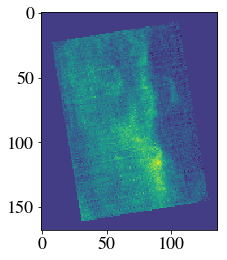

In [19]:
plt.imshow(image)

0.22081724


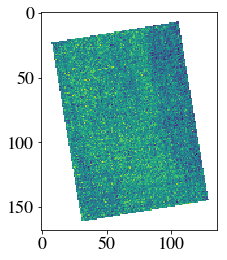

In [23]:
plt.imshow(mask)
print(mask[50,100])

In [1]:
import turtle


In [2]:
def drawTriangle(points,color,myTurtle):
    myTurtle.fillcolor(color)
    myTurtle.up()
    myTurtle.goto(points[0][0],points[0][1])
    myTurtle.down()
    myTurtle.begin_fill()
    myTurtle.goto(points[1][0],points[1][1])
    myTurtle.goto(points[2][0],points[2][1])
    myTurtle.goto(points[0][0],points[0][1])
    myTurtle.end_fill()

def getMid(p1,p2):
    return ( (p1[0]+p2[0]) / 2, (p1[1] + p2[1]) / 2)

def sierpinski(points,degree,myTurtle):
    colormap = ['blue','red','green','white','yellow',
                'violet','orange']
    drawTriangle(points,colormap[degree],myTurtle)
    if degree > 0:
        sierpinski([points[0],
                        getMid(points[0], points[1]),
                        getMid(points[0], points[2])],
                   degree-1, myTurtle)
        sierpinski([points[1],
                        getMid(points[0], points[1]),
                        getMid(points[1], points[2])],
                   degree-1, myTurtle)
        sierpinski([points[2],
                        getMid(points[2], points[1]),
                        getMid(points[0], points[2])],
                   degree-1, myTurtle)

def main():
   myTurtle = turtle.Turtle()
   myWin = turtle.Screen()
   myPoints = [[-100,-50],[0,100],[100,-50]]
   sierpinski(myPoints,3,myTurtle)
   myWin.exitonclick()

main()
